# Final Project: *Statistical analysis of Dissolved Oxygen (DO) in the Terminos Lagoon*

Author: *Mayte Vizcarra Ramos*

## 1. Introduction

This report presents a statistical analysis of dissolved oxygen (DO) in the Términos Lagoon, a tropical estuarine system of ecological and socio-economic importance. The study investigates how DO, temperature, and salinity vary across spatial zones (River, Plume, and Coast) and between seasonal conditions (Dry and Rainy). Because DO is a key indicator of water quality, understanding its variability provides valuable insights into the hydrological and ecological functioning of the lagoon. To achieve this, the analysis applied robust statistical methods: Shapiro–Wilk tests for normality, Mann–Whitney U tests for seasonal comparisons, Kruskal–Wallis tests with Dunn’s post-hoc analysis for spatial differences, and Pearson correlation to assess linear associations among variables. This framework allowed the identification of both seasonal and spatial drivers of water quality.

In [ ]:
## Basic setup & path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tabulate import tabulate
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import statsmodels.api as sm
import scikit_posthocs as sp

def import_csv(file):
    return pd.read_csv(file)
path = "../Curso_Python_Mayte/data/Terminos_lagoon_TA_DIC_2023_RawData.csv"


In [52]:
# Quick overview
file= import_csv(path)
file.head()

,sample,date,estuary,area,station,layer_depth,season,chlorophy_microg_l,cond_microsiemens_cm,depth_m,...,do_mg_l,sal_psu,sp_cond_microsiemens_cm,turbidity_fnu,temp_c,latitude,longitude,dic_micromol_kg,ta_micromol_kg,dummy_data
0,CDL01S,5/3/2020,Candelaria,River,CDL01,Surface,Dry,0.36,7015.4,0.464,...,7.12,3.56,6547.7,1.47,28.740,18.55736,-91.25012,3915,3863,3685.0
1,CDL01F,5/3/2020,Candelaria,River,CDL01,Bottom,Dry,4.19,29886.1,7.792,...,4.90,16.97,27751.2,95.33,29.028,18.55722,-91.24990,3698,3685,NaN
2,CDL02S,5/3/2020,Candelaria,River,CDL02,Surface,Dry,0.92,16691.1,0.453,...,6.99,8.94,15429.1,5.50,29.283,18.61007,-91.24410,3724,3708,3708.0
3,CDL02F,5/3/2020,Candelaria,River,CDL02,Bottom,Dry,2.23,24847.4,1.261,...,6.52,13.87,23074.0,13.44,29.024,18.61005,-91.24403,3667,3992,3992.0
4,CDL03S,5/3/2020,Candelaria,River,CDL03,Surface,Dry,0.58,46341.6,0.465,...,6.24,28.06,43670.8,3.60,28.202,18.63166,-91.29359,2928,3023,3023.0


In [26]:
## Statical definitions

### Normality test
def evaluation_data(dat):
    if len(dat)< 2000:
        print("The data of " + dat.name +" is " + str(len(dat)) +" rows long. Use the Shapiro-Wilk test.")
    else:
        print("The data of " + dat.name +" is " + str(len(dat)) + " rows long. Use the Kolmogorov-Smirnov test.")
        return None

def Shapiro_Wilk_test(dat):
    from scipy.stats import shapiro 
    stat, p = shapiro(dat)
    print(f'Statistic= {stat:.5f}, p-value= {p:.5f}')
    if p < 0.05:
     print("The data of " + dat.name +" is not normally distributed (reject H₀). Apply a non-parametric test.")

    else:
       print("The data of" + dat.name +" is normally distributed (fail to reject H₀).")
    return None

## Non-parametric tests
### Mann-Whitney U test

def mann_whitney_test(data1, data2, alpha=0.05):
    """
    Performs the Mann-Whitney U test and prints U statistic, p-value, and result.
    """
    result = mannwhitneyu(data1, data2, alternative='two-sided')
    
    print(f"U statistic = {result.statistic}")
    print(f"p-value = {result.pvalue}")

    if result.pvalue < alpha:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

### Kruskal-Wallis H test

def kruskal_wallis_test(*groups, alpha=0.05):
    """
    Performs the Kruskal-Wallis H-test for independent samples.
    Accepts multiple groups as arguments.
    Prints the H statistic, p-value, and interpretation.
    """
    result = kruskal(*groups)
    
    print(f"H statistic = {result.statistic}")
    print(f"p-value = {result.pvalue}")
    
    if result.pvalue < alpha:
        print("The difference between groups is statistically significant.")
    else:
        print("No statistically significant difference between groups.")

def dunn_posthoc(data, group_col, value_col, p_adjust='bonferroni'):
    """
    Runs Dunn's post-hoc test after Kruskal-Wallis.
    """
    result = sp.posthoc_dunn(data, val_col=value_col, group_col=group_col, p_adjust=p_adjust)
    print(result)
    return result

### Spearman correlation test
def test_spearman(x, y, alpha=0.05):
    if len(x) != len(y):
        raise ValueError("Las variables deben tener la misma longitud.")

    rho, pval = stats.spearmanr(x, y)

    print(f"Spearman's correlation coefficient (rho): {rho:.3f}")
    print(f"p-value: {pval:.4f}")

    if pval < alpha:
        print(f"✔️ Significant relationship (p < {alpha:.3f})")
    else:
        print(f"⚠️ No significant relationship (p ≥ {alpha:.3f})")

    if rho > 0:
        print("📈 Positive correlation")
    else:
        print("📉 Negative correlation")

### Pearson correlation test

def pearson_corr(x, y, alpha=0.05):
    if len(x) != len(y):
        raise ValueError("Las variables deben tener la misma longitud.")
    
    r, pval = stats.pearsonr(x, y)

    print(f"Pearson correlation coefficient (r): {r:.4f}")
    print(f"P-value: {pval:.4f}")

    if pval < alpha:
        print(f"✔️ Significant relationship (p < {alpha:.3f})")
    else:
        print(f"⚠️ No significant relationship (p ≥ {alpha:.3f})")

    if r > 0:
        print("📈 Positive correlation")
    elif r == 0:
        print("➖ No correlation")
    else: 
        print("📉 Negative correlation")
    return None



In [53]:
# Select data
do_data = file["do_mg_l"]
temp_data = file["temp_c"]
sal_data = file["sal_psu"]

In [54]:
# Calculate the mean and standard deviation of the "do_data" for each season and area
variables = ['do_mg_l', 'temp_c', 'sal_psu']
res_ar_sea= file.groupby(['season', 'area'])[variables].agg(['mean', 'std']).reset_index().round(2)

res_ar_sea.columns = ['season', 'area'] + [f"{var}_{stat}" for var in variables for stat in ['mean', 'std']]
for var in variables:
    mean_col = f"{var}_mean"
    std_col = f"{var}_std"
    res_ar_sea[f"{var} (mean ± sd)"] = res_ar_sea.apply(lambda row: f"{row[mean_col]:,.2f} ± {row[std_col]:,.2f}", axis=1)

res_ar_sea_for = res_ar_sea[['season', 'area'] + [f"{var} (mean ± sd)" for var in variables]]

In [56]:
#Display the table with the formatted results using tabulate

t = tabulate(res_ar_sea[['season', 'area', 'do_mg_l (mean ± sd)', 'temp_c (mean ± sd)', 'sal_psu (mean ± sd)']], headers='keys', tablefmt='pretty', showindex=False)
print("\n=== Results by season and area ===")
print(t)


=== Results by season and area ===
+--------+-------+---------------------+--------------------+---------------------+
| season | area  | do_mg_l (mean ± sd) | temp_c (mean ± sd) | sal_psu (mean ± sd) |
+--------+-------+---------------------+--------------------+---------------------+
|  Dry   | Coast |     7.09 ± 0.83     |    25.89 ± 0.69    |    31.14 ± 6.10     |
|  Dry   | Plume |     7.19 ± 2.16     |    26.71 ± 0.97    |    22.63 ± 9.96     |
|  Dry   | River |     6.89 ± 2.25     |    27.11 ± 1.04    |     6.28 ± 9.28     |
| Rainy  | Coast |     6.42 ± 1.10     |    27.24 ± 0.34    |    22.06 ± 12.62    |
| Rainy  | Plume |     4.79 ± 3.02     |    27.34 ± 0.32    |    11.04 ± 7.71     |
| Rainy  | River |     4.39 ± 1.28     |    26.90 ± 0.26    |     0.92 ± 2.21     |
+--------+-------+---------------------+--------------------+---------------------+


Histograms

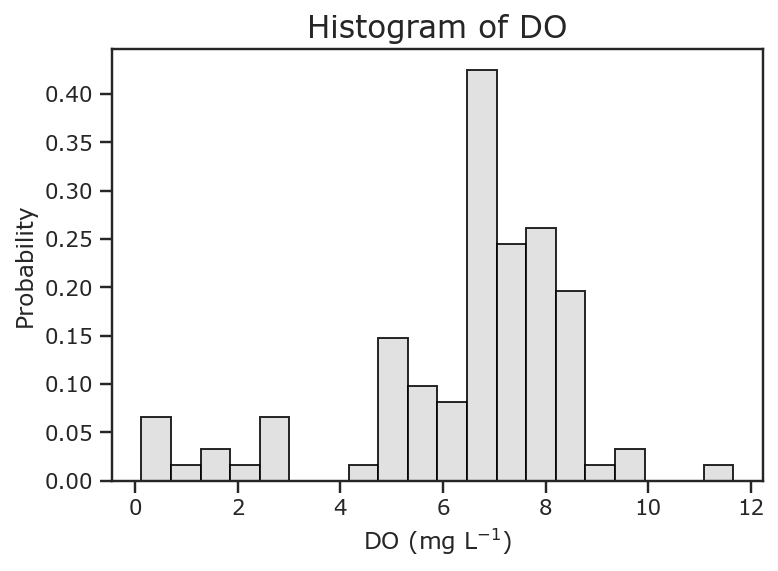

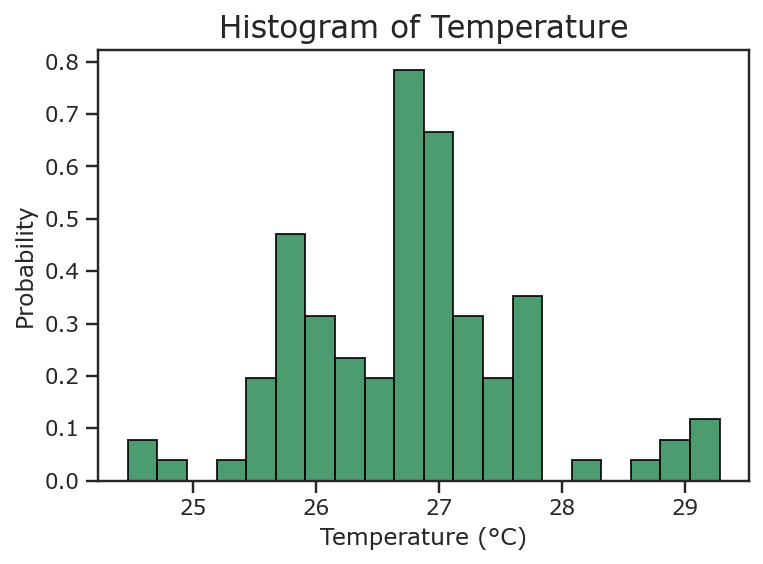

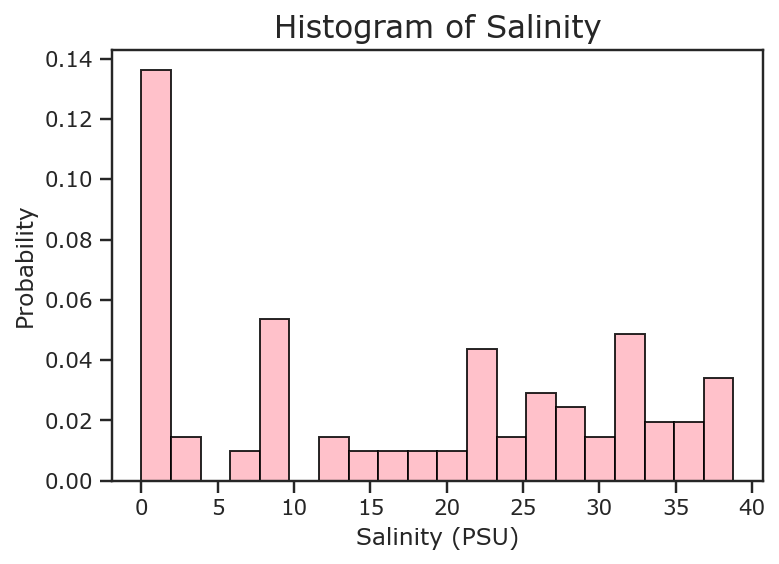

In [58]:
# DO
plt.figure(figsize=(6,4), dpi=140)
plt.hist(do_data, bins=20, density=True, edgecolor="black", alpha=0.85, color='gainsboro')
plt.xlabel('DO (mg L$^{-1}$)', fontname='Verdana', fontsize=12)
plt.ylabel('Probability', fontname='Verdana', fontsize=12)
plt.title('Histogram of DO', fontname='Verdana', fontsize=16)
plt.show()

# Temperature
plt.figure(figsize=(6,4), dpi=140)
plt.hist(temp_data, bins=20, density=True, edgecolor="black", alpha=0.85, color='seagreen')
plt.xlabel('Temperature (°C)', fontname='Verdana', fontsize=12)
plt.ylabel('Probability', fontname='Verdana', fontsize=12)
plt.title('Histogram of Temperature', fontname='Verdana', fontsize=16)
plt.show()

# Salinity
plt.figure(figsize=(6,4), dpi=140)
plt.hist(sal_data, bins=20, density=True, edgecolor="black", alpha=0.85, color='lightpink')
plt.xlabel('Salinity (PSU)', fontname='Verdana', fontsize=12)
plt.ylabel('Probability', fontname='Verdana', fontsize=12)
plt.title('Histogram of Salinity', fontname='Verdana', fontsize=16)
plt.show()

Normality test

In [59]:
Shapiro_Wilk_test(do_data)
Shapiro_Wilk_test(temp_data)
Shapiro_Wilk_test(sal_data)

Statistic= 0.87866, p-value= 0.00000
The data of do_mg_l is not normally distributed (reject H₀). Apply a non-parametric test.
Statistic= 0.96010, p-value= 0.00288
The data of temp_c is not normally distributed (reject H₀). Apply a non-parametric test.
Statistic= 0.88666, p-value= 0.00000
The data of sal_psu is not normally distributed (reject H₀). Apply a non-parametric test.


The Shapiro–Wilk test indicated that dissolved oxygen (DO), temperature, and salinity do not follow a normal distribution (all p < 0.05). Consequently, non-parametric procedures were selected for inferential analyses, which are more robust to deviations from normality.

### Non parametric test
#### Mann-Whitney U

In [ ]:
do_dry = file.loc[file["season"] == "Dry", "do_mg_l"]
do_rainy = file.loc[file["season"] == "Rainy", "do_mg_l"]
temp_dry = file.loc[file["season"] == "Dry", "temp_c"]
temp_rainy = file.loc[file["season"] == "Rainy", "temp_c"]
sal_dry = file.loc[file["season"] == "Dry", "sal_psu"]
sal_rainy = file.loc[file["season"] == "Rainy", "sal_psu"]

# Perform the Mann-Whitney U test for DO, temperature and salinity between dry and rainy seasons
mann_whitney_test(do_dry, do_rainy)
mann_whitney_test(temp_dry, temp_rainy)
mann_whitney_test(sal_dry, sal_rainy)

U statistic = 1865.0
p-value = 1.454848248303862e-05
The difference is statistically significant.
U statistic = 551.0
p-value = 5.317160670684041e-06
The difference is statistically significant.
U statistic = 1660.0
p-value = 0.003199701027350606
The difference is statistically significant.


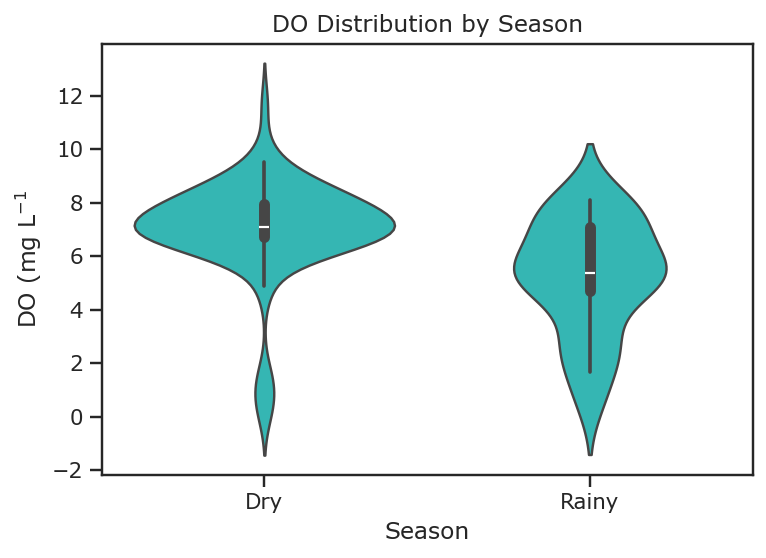

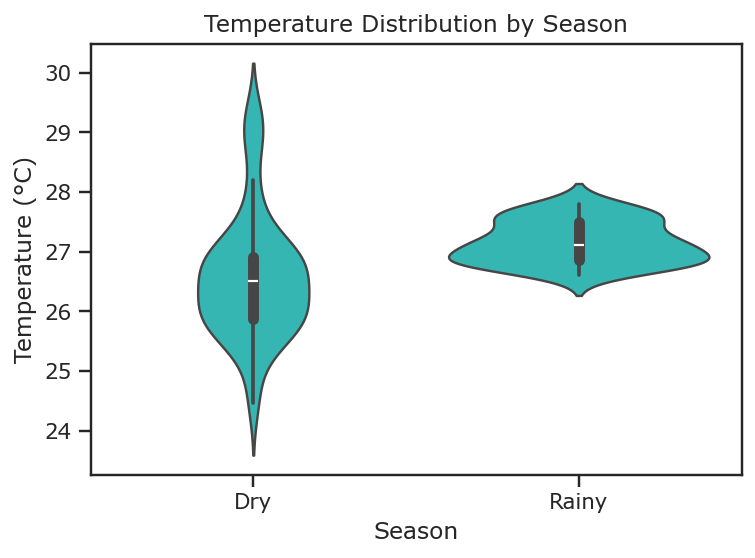

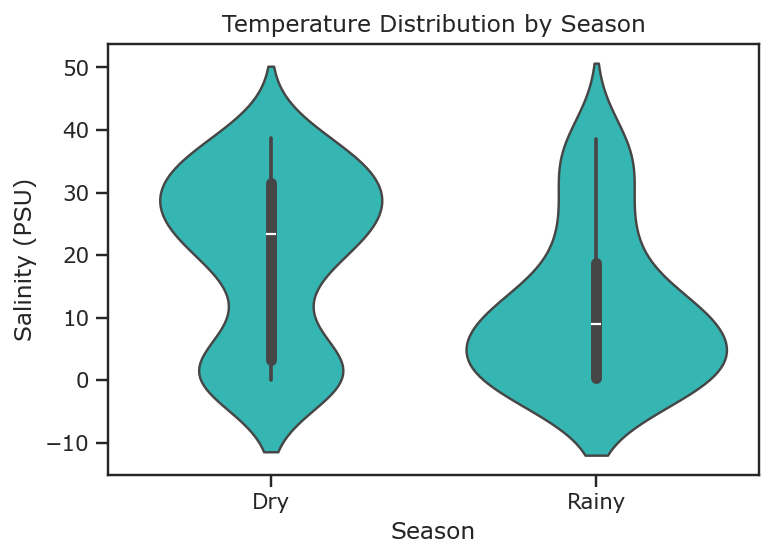

In [64]:


my_colors = ["#20CBC8", "#2222e8", "#0EB781"]
sns.set(font_scale=1, style="ticks", palette= my_colors, font='Verdana')

# Violin plot of DO by season
plt.figure(figsize=(6,4), dpi=140)
sns.violinplot(x='season', y='do_mg_l', data=file)
plt.title('DO Distribution by Season')
plt.xlabel('Season')
plt.ylabel('DO (mg L$^{-1}$')
plt.show()

# Violin plot of Temperature by season
plt.figure(figsize=(6,4), dpi=140)
sns.violinplot(x='season', y='temp_c', data=file)
plt.title('Temperature Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')
plt.show()

# Violin plot of Salinity by season
plt.figure(figsize=(6,4), dpi=140)
sns.violinplot(x='season', y='sal_psu', data=file)
plt.title('Temperature Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Salinity (PSU)')
plt.show()



#### Seasonal comparisons (Mann–Whitney U)

The Mann–Whitney U test showed significant seasonal differences for all variables. DO was lower in the rainy season, reflecting reduced oxygen availability. Temperature was slightly but significantly higher during the rainy season. Salinity dropped markedly in the rainy season due to freshwater inflows. These results confirm that seasonality strongly influences water quality in the lagoon.

### Krustal Wallis test

In [62]:
do_river = file[file['area'] == 'River']['do_mg_l']
do_plume = file[file['area'] == 'Plume']['do_mg_l']
do_coast= file[file['area'] == 'Coast']['do_mg_l']
temp_river = file[file['area'] == 'River']['temp_c']
temp_plume = file[file['area'] == 'Plume']['temp_c']
temp_coast= file[file['area'] == 'Coast']['temp_c']
sal_river = file[file['area'] == 'River']['sal_psu']
sal_plume = file[file['area'] == 'Plume']['sal_psu']
sal_coast= file[file['area'] == 'Coast']['sal_psu']

In [67]:
kruskal_wallis_test(do_river, do_plume, do_coast)
dunn_posthoc(file, 'area', 'do_mg_l')

H statistic = 0.9576951112185427
p-value = 0.6194969163247974
No statistically significant difference between groups.
       Coast     Plume     River
Coast    1.0  1.000000  1.000000
Plume    1.0  1.000000  0.987396
River    1.0  0.987396  1.000000


,Coast,Plume,River
Coast,1.0,1.000000,1.000000
Plume,1.0,1.000000,0.987396
River,1.0,0.987396,1.000000


In [68]:
kruskal_wallis_test(temp_river, temp_plume, temp_coast)
dunn_posthoc(file, 'area', 'temp_c')


H statistic = 7.6996429549091365
p-value = 0.021283535690208223
The difference between groups is statistically significant.
          Coast    Plume     River
Coast  1.000000  0.06468  0.038761
Plume  0.064680  1.00000  1.000000
River  0.038761  1.00000  1.000000


,Coast,Plume,River
Coast,1.000000,0.06468,0.038761
Plume,0.064680,1.00000,1.000000
River,0.038761,1.00000,1.000000


In [69]:
kruskal_wallis_test(sal_river, sal_plume, sal_coast)
dunn_posthoc(file, 'area', 'sal_psu')

H statistic = 55.88358275387142
p-value = 7.328822281550146e-13
The difference between groups is statistically significant.
              Coast     Plume         River
Coast  1.000000e+00  0.007636  3.060998e-13
Plume  7.635777e-03  1.000000  3.407869e-05
River  3.060998e-13  0.000034  1.000000e+00


,Coast,Plume,River
Coast,1.000000e+00,0.007636,3.060998e-13
Plume,7.635777e-03,1.000000,3.407869e-05
River,3.060998e-13,0.000034,1.000000e+00


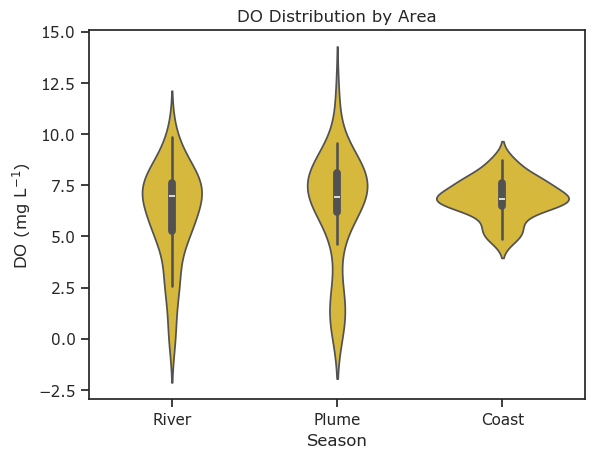

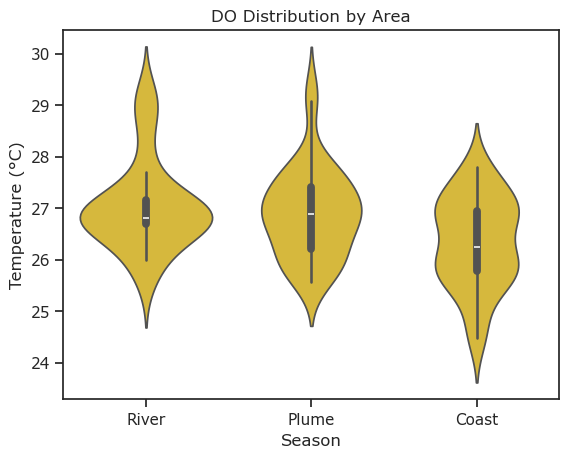

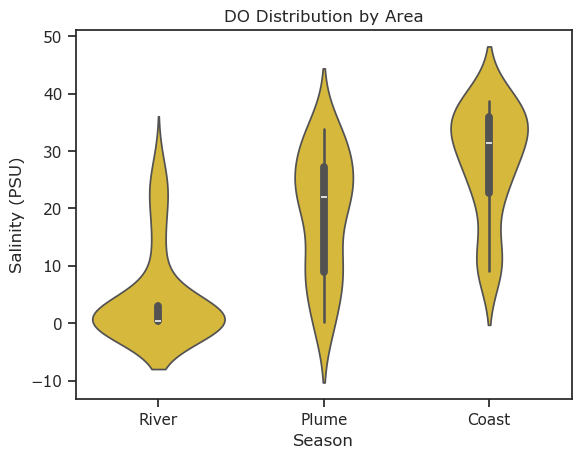

In [66]:
# Violinplot of DO by area of the lagoon
my_colors_2 = ["#EFC724", "#e5e822", "#D67538"]
sns.set(font_scale=1, style="ticks", palette= my_colors_2, font='Verdana')
sns.violinplot(x='area', y='do_mg_l', data=file)
plt.title('DO Distribution by Area')
plt.xlabel('Season')
plt.ylabel('DO (mg L$^{-1}$)')
plt.show()

# Violinplot of Temperature by area of the lagoon
sns.violinplot(x='area', y='temp_c', data=file)
plt.title('DO Distribution by Area')
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')
plt.show()

# Violinplot of Salinity by area of the lagoon
sns.violinplot(x='area', y='sal_psu', data=file)
plt.title('DO Distribution by Area')
plt.xlabel('Season')
plt.ylabel('Salinity (PSU)')
plt.show()


The Kruskal–Wallis tests revealed contrasting patterns among variables across the River, Plume, and Coast areas. Dissolved oxygen (DO) showed no significant spatial differences, suggesting that oxygen levels are primarily shaped by seasonal dynamics rather than location. Temperature displayed moderate spatial variability, with rivers slightly warmer than coastal waters, while plumes acted as transitional zones. In contrast, salinity exhibited highly significant spatial differences, clearly reflecting the hydrological gradient: freshwater in rivers, mixed conditions in plumes, and marine influence at the coast.

### Pearson correlation

In [44]:
pearson_corr(file['do_mg_l'], file['sal_psu'])

Pearson correlation coefficient (r): 0.0725
P-value: 0.4600
⚠️ No significant relationship (p ≥ 0.050)
📈 Positive correlation


In [45]:
pearson_corr(file['do_mg_l'], file['temp_c'])

Pearson correlation coefficient (r): -0.0618
P-value: 0.5292
⚠️ No significant relationship (p ≥ 0.050)
📉 Negative correlation


The Pearson test indicates that DO is not linearly correlated with either salinity or temperature in the dataset. While there are seasonal and spatial differences (detected by Mann–Whitney and Kruskal–Wallis tests), these patterns are non-linear and influenced by complex hydrological–biological interactions.

## Conclusion

The results demonstrate that dissolved oxygen in the Términos Lagoon is mainly influenced by seasonal dynamics rather than spatial location. DO concentrations were significantly lower during the rainy season, reflecting the impact of freshwater inflows and organic matter enrichment. In contrast, spatial analyses showed that salinity was the strongest discriminator among areas, clearly separating rivers, plumes, and coastal waters, while temperature differences were more moderate. The Pearson test confirmed that DO does not exhibit strong linear correlations with either salinity or temperature, suggesting that its variability is shaped by complex hydrological and ecological processes. Overall, this project highlights the importance of seasonal forcing and hydrological gradients as key drivers of lagoon water quality and underlines the value of continued monitoring to support ecosystem management.

## References

Chuang, P. C., Young, M. B., Dale, A. W., Miller, C. E., Weinstein, A. J., González, C. J., ... & Paytan, A. (2017). Methane fluxes from tropical coastal lagoons surrounded by mangroves, Gulf of Mexico. Journal of Geophysical Research: Biogeosciences, 122(11), 3041–3057. https://doi.org/10.1002/2017JG003761

Fichez, R., Gutiérrez, F., Lefebvre, J. P., Origel, M., Pinazo, C., & Stein, R. (2016). JEST: Joint Environmental Study of the Términos Lagoon, Southern Gulf of Mexico. Continental Shelf Research, 118, 1–16. https://doi.org/10.1016/j.csr.2016.02.005